In [1]:
# Standard
import numpy as np
import os
import glob
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
from moviepy.editor import VideoFileClip,ImageSequenceClip

# Pre processing
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle

# Modeling
from sklearn import svm

# Post processing
from scipy.ndimage.measurements import label


%matplotlib inline
model_file = 'model.pkl'
scaler_file = 'scaler.pkl'

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    
    # Convert to another color space
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


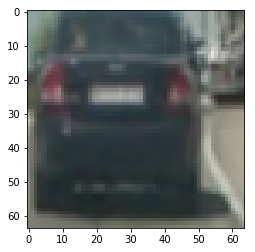

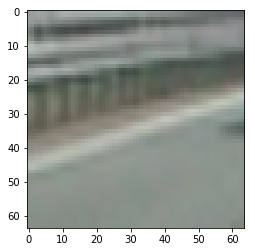

In [3]:
# Choose test image
veh_dir = './vehicles/'
non_veh_dir = './non-vehicles/non-vehicles/'
veh_file_name = 'GTI_MiddleClose/image0003.png'
non_veh_file_name = 'GTI/image176.png'

img = mpimg.imread(os.path.join(veh_dir,veh_file_name))
plt.imshow(img)
plt.savefig('./output_images/test_veh.jpg')

# Define a window size as the size of the training data examples
window_pix = img.shape[0]

# Show non vehicle
plt.figure()
non_img = mpimg.imread(os.path.join(non_veh_dir,non_veh_file_name))
plt.imshow(non_img)
plt.savefig('./output_images/test_non_veh.jpg')




Features shape (5, 5, 4, 4, 9)


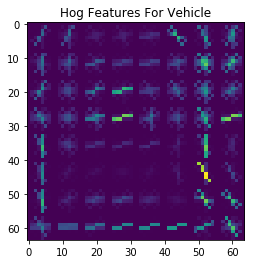

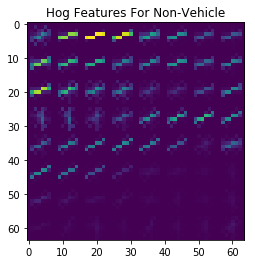

In [4]:
# Choose paramters for HOG features

num_orientations = 9
pix_per_cell = 8
cell_per_block = 4

hog_features,hog_image = get_hog_features(img,num_orientations,pix_per_cell,cell_per_block,vis=True
                                     ,feature_vec = False)

print('Features shape',hog_features.shape)
plt.imshow(hog_image)
plt.title('Hog Features For Vehicle')
plt.savefig('./output_images/hog_image.jpg')

hog_features,hog_image = get_hog_features(non_img,num_orientations,pix_per_cell,cell_per_block,vis=True
                                     ,feature_vec = False)

plt.figure()
plt.imshow(hog_image)
plt.title('Hog Features For Non-Vehicle')
plt.savefig('./output_images/hog_image_non_car.jpg')

In [5]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(hsv[:,:,0], bins=nbins)
    channel2_hist = np.histogram(hsv[:,:,1], bins=nbins)
    channel3_hist = np.histogram(hsv[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

Features shape (96,)


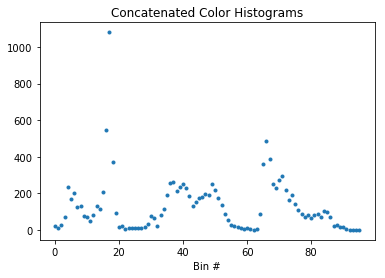

In [6]:
# Choose paramters for color histogram

nbins = 32

color_hist_features = color_hist(img,nbins)
print('Features shape',color_hist_features.shape)

# Plot
plt.plot(color_hist_features,'.')
plt.xlabel('Bin #')
plt.title('Concatenated Color Histograms')
plt.savefig('./output_images/color_histogram.jpg')

## Load and Pre-Process Data

In [9]:
# Load vehicle data
def get_img_data(file_expression,test=False):
    
    data_array = []
    for i,file_name in enumerate(glob.iglob(file_expression)):
        # Preprocess
        img = mpimg.imread(file_name)
        
        hog_features = get_hog_features(img,num_orientations,pix_per_cell,cell_per_block
                                        ,vis=False,feature_vec = True)
        
        color_hist_features = color_hist(img,nbins)
        
        # Combine
        combined_features = np.hstack((hog_features.ravel(),color_hist_features.ravel()))
        
        # Declare final version of X        
        X_row = combined_features

        
        # Add to list
        if test and (i >= 100): break            
        data_array.append(X_row)
            
    return np.array(data_array)

test = False

veh_expression = os.path.join(veh_dir,'*/*.png')
veh_array = get_img_data(veh_expression,test)
veh_targets = np.ones(len(veh_array),dtype = int)

non_veh_expression = os.path.join(non_veh_dir,'*/*.png')
non_veh_array = get_img_data(non_veh_expression,test)
non_veh_targets = np.zeros(len(non_veh_array), dtype = int)

In [10]:
print(veh_array.shape)
print(non_veh_array.shape)

(8792, 3696)
(8968, 3696)


In [11]:
# Combine veh and non-veh data
X = np.vstack([veh_array,non_veh_array])
y = np.hstack([veh_targets,non_veh_targets])



In [17]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
print('Training set shape',X_train.shape)
print('Testing set shape',X_test.shape)
print('Training mean %.2f'%np.mean(y_train))

Training set shape (14208, 3696)
Testing set shape (3552, 3696)
Training mean 0.50


In [19]:
y_train[0:50].T # check randomness

array([ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
        0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.])

## Train and evaluate SVM model

In [20]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

from time import time
from sklearn.svm import SVC
# clf = SVC()
# t0 = time()
# clf.fit(X_train, y_train)
# print("training time:", int(time()-t0) )

clf = svm.SVC(C=0.5,kernel='rbf', gamma='auto',verbose=True,probability=True)
clf.fit(scaled_X_train,y_train)

In [22]:
# Evaluate on test and train sets
print('Train Accuracy of SVC = ', clf.score(scaled_X_train, y_train))
print('Test Accuracy of SVC = ', clf.score(scaled_X_test, y_test))

Train Accuracy of SVC =  0.994017454955
Test Accuracy of SVC =  0.98902027027


In [23]:
# Save model

with open(model_file,'wb') as f:
    pickle.dump(clf,f)
    
# Save scaler

with open(scaler_file,'wb') as f:
    pickle.dump(X_scaler,f)

In [24]:
# Remove variables to free up memory
def clear_vars():
    del X
    del X_train
    del X_test
    del scaled_X_train
    del scaled_X_test
#clear_vars()   

## Sliding Window Search

1. explore data to decide target area and window sizes for different area
2. create a list of sliding window
3. test svm model
4. hotmap

In [25]:
# Load pre-trained model
with open(model_file,'rb') as f:
    clf = pickle.load(f)
    
# Load pre-trained scaler
with open(scaler_file,'rb') as f:
    X_scaler = pickle.load(f)

In [40]:
# create a folder to store extracted images
import os
folder = 'project_frame'  
#os.mkdir(folder)



In [50]:
def get_frames(sec_in_video,process=True,all_frames=False):
    out_images = []
    clip = VideoFileClip("project_video.mp4")
    
    frame_num = sec_in_video * 25
    
    for i,img in enumerate(clip.iter_frames()):

        if (i < frame_num) and not all_frames:
            continue
        elif (i > (frame_num + 50)) and not all_frames:
            continue
        else:
            if process:
                out_images.append(process_image(img))
            else:
                out_images.append(img)
        
    return out_images


frames = get_frames(30,process=False) #notable seconds: 8,23 (missed car),39,45 (missed car)
test_img = frames[0]

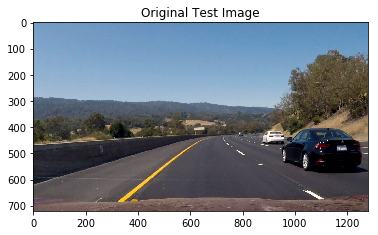

In [51]:
plt.imshow(test_img)
plt.title('Original Test Image')
plt.savefig('./output_images/test_image.jpg')

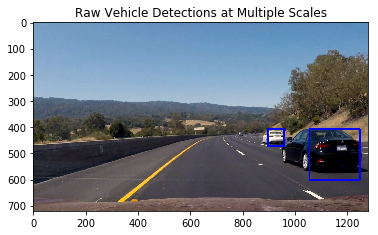

In [52]:
def find_cars(img):
    '''Find cars by running repeatedly running find_cars_one_scale on multiple scales'''
        
    #scale_list = [1,2,3,4]
    scale_list = [1,2,3]
    bbox_list = []
    for scale in scale_list:
        veh_found = find_cars_one_scale(img,scale,draw_grid=False,stride_frac = 0.25)
        bbox_list.extend(veh_found)

    # Make copy to draw found vehicles on
    draw_img = np.copy(img)
    for (pt1,pt2) in bbox_list:
        cv2.rectangle(draw_img,pt1,pt2,(0,0,255),6)

    return draw_img,bbox_list

draw_img,bbox_list = find_cars(test_img)
plt.imshow(draw_img)
plt.title('Raw Vehicle Detections at Multiple Scales')
plt.savefig('./output_images/test_image_with_detections.jpg')

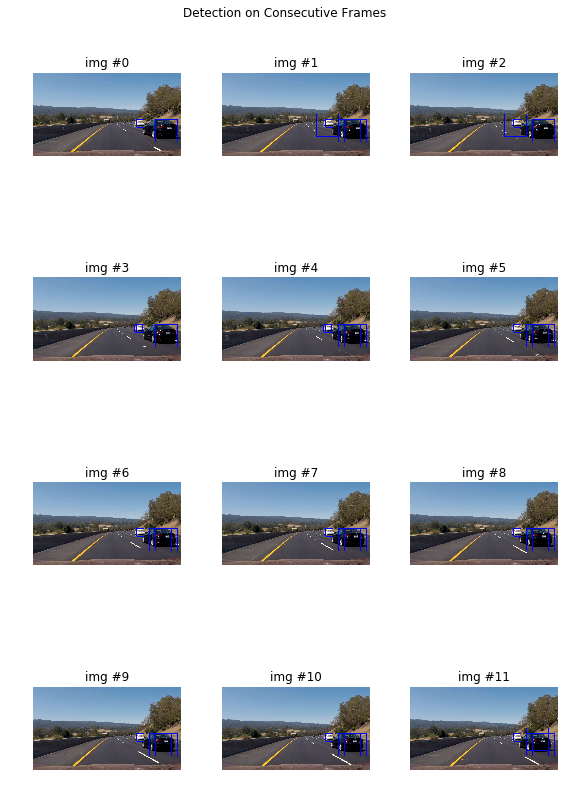

In [48]:
num_frames_to_save_boxes = 12
multi_frame_bbox_list = []

f,axarr = plt.subplots(4,3,figsize=(8,12))
for i,(img,ax) in enumerate(zip(frames[:num_frames_to_save_boxes],axarr.flatten())):
    draw_img,bbox_list = find_cars(img)
    ax.imshow(draw_img)
    ax.set_title('img #%i'%i)
    ax.axis('off')
    
    # Implement queue of last few frames. Had trouble with the queue module so chose a simpler approach
    multi_frame_bbox_list.append(bbox_list)
    if len(multi_frame_bbox_list) > num_frames_to_save_boxes:
        multi_frame_bbox_list.pop(0)

# Collapse list of bboxes accross frames into one long list
multi_frame_bbox_list = [box for bbox_list in multi_frame_bbox_list for box in bbox_list]
        
plt.suptitle('Detection on Consecutive Frames')
plt.savefig('./output_images/consecutive_detections.jpg')
plt.tight_layout()

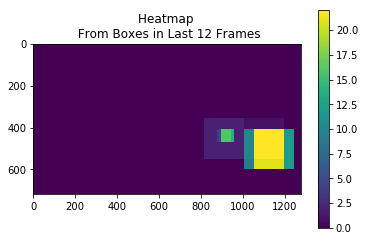

In [53]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Visualize heatmap for last image
heatmap = np.zeros_like(test_img[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap,multi_frame_bbox_list)
plt.imshow(heatmap)
plt.colorbar()
plt.title('Heatmap \n From Boxes in Last %i Frames'%num_frames_to_save_boxes)
plt.savefig('./output_images/heatmap.jpg')

2 cars found


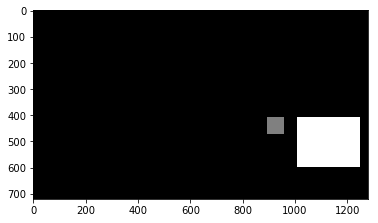

In [54]:
# Threshold and apply label
threshold = 6
heatmap[heatmap <= threshold] = 0
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.savefig('./output_images/thresholded_boxes.jpg')

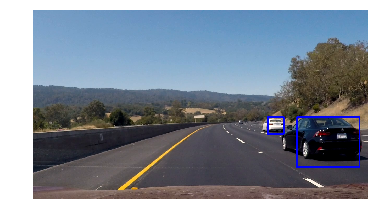

In [56]:
num_final_boxes = 12
final_box_list = []

def draw_labeled_bboxes(img, labels,final_boxes=False):

    img_boxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        img_boxes.append(bbox)
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
        # Optional, place car number on screen
        #cv2.putText(img,str(car_number),bbox[0],cv2.FONT_HERSHEY_PLAIN,3,(255,0,0),5)

    if not final_boxes:
        # Add to list for smoothing
        final_box_list.append(img_boxes)
        if len(final_box_list) > num_final_boxes:
            final_box_list.pop(0)
    
    # Return the image
    return img

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.imshow(draw_img)
plt.axis('off')
plt.savefig('./output_images/final_image.jpg')

## Final Function and Compile Video

In [57]:
multi_frame_bbox_list = [] #reset box history
final_box_list = [] # reset final box history

def process_image(img):
    _,bbox_list = find_cars(img)
    multi_frame_bbox_list.append(bbox_list)
    if len(multi_frame_bbox_list) > num_frames_to_save_boxes:
            multi_frame_bbox_list.pop(0)

    # Collapse list of bboxes accross frames into one long list
    compiled_bbox_list = [box for bbox_list in multi_frame_bbox_list for box in bbox_list]
    
    # Heatmap
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap,compiled_bbox_list)

    # Theshold
    heatmap[heatmap <= threshold] = 0
    labels = label(heatmap)

    # Draw boxes and add to list of final boxes    
    draw_labeled_bboxes(np.copy(img), labels)    
    
    
    ## Compile list of final boxes and plot their heatmap
    final_compiled_box_list = [box for bbox_list in final_box_list for box in bbox_list]
    
    # Heatmap
    final_heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    final_heatmap = add_heat(final_heatmap,final_compiled_box_list)

    # Theshold
    final_threshold = 6 # Need this many frames before showing
    final_heatmap[final_heatmap <= final_threshold] = 0
    final_labels = label(final_heatmap)

    # Draw
    draw_img = draw_labeled_bboxes(np.copy(img), final_labels,final_boxes=True)
    
    #plt.imshow(final_heatmap)        
    return draw_img

# Do not plot output because it reset's output so there's only one frame processed
draw_img = process_image(test_img)


In [58]:
# Test of small portion of video

sec_in_video = 17

multi_frame_bbox_list = [] #reset box history
final_box_list = [] # reset final box history

%time out_images = get_frames(sec_in_video,process=True,all_frames=False) #notable seconds: 8,39,45 (missed car)

output_video = 'project_output_test.mp4'
clip = ImageSequenceClip(out_images, fps=25)
%time clip.write_videofile(output_video, audio=False)

CPU times: user 8min 15s, sys: 836 ms, total: 8min 16s
Wall time: 8min 18s
[MoviePy] >>>> Building video project_output_test.mp4
[MoviePy] Writing video project_output_test.mp4


100%|██████████| 52/52 [00:00<00:00, 87.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_test.mp4 

CPU times: user 48 ms, sys: 48 ms, total: 96 ms
Wall time: 1.24 s


## Select frames from video to set parameters

In [74]:
multi_frame_bbox_list = [] #reset box history
final_box_list = [] # reset final box history

def compile_video(test=False):
    # Import everything needed to edit/save/watch video clips

    output_video = 'project_output.mp4'
    input_video = "project_video.mp4"
    if test: input_video = 'test_video.mp4'
    clip1 = VideoFileClip(input_video)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(output_video, audio=False)
   
    return output_video

compile_video(test=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [3:21:29<00:09,  9.52s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 3h 21min 8s, sys: 3.78 s, total: 3h 21min 11s
Wall time: 3h 21min 30s


'project_output.mp4'